Problem Set 1: Text Classification
=============

In this problem set, you will build a system for automatically classifying song lyrics comments by era. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a machine learning classifier based on the discriminative model, using Perceptron
- Build a logistic regression classifier using PyTorch
- Implement techniques to improve your classifier, and compete on Kaggle

# 0. Setup

In order to develop this assignment, you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```gtnlplib```.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, run the script ```make-submission.sh```, and submit the tarball ```pset1-submission.tgz``` on Canvas.**

In [1]:
import sys
from importlib import reload

In [2]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.6.4 (default, Jan 13 2018, 17:11:19) 
[GCC 4.8.4]


In [129]:
import nose

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

%matplotlib inline

In [130]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 0.22.0
numpy: 1.14.0
scipy: 1.0.0
matplotlib: 2.1.1
nose: 1.3.7
torch: 0.3.0.post4


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [131]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# 1. Preprocessing

Total: 1 point

Read the data into a dataframe

In [6]:
df_train = pd.read_csv('lyrics-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [7]:
df_train.head()

,Era,Lyrics
0,pre-1980,come on come on let me show you where its at a...
1,1980s,welcome to the big time youre bound to be a s...
2,pre-1980,once i believed that when love came to me it ...
3,2000s,i took my love and i took it down climbed a m...
4,pre-1980,do do do do do do do do do do do do do do do ...


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each instance.

- **Deliverable 1.1**: Complete the function `gtnlplib.preproc.bag_of_words`. (0.25 points)
- **Test**: `nose tests/test_preproc.py:test_d1_1_bow`

In [8]:
from gtnlplib import preproc

In [9]:
# run this block to update the notebook as you change the preproc library
reload(preproc);

In [10]:
y_tr,x_tr = preproc.read_data('lyrics-train.csv',preprocessor=preproc.bag_of_words)
y_dv,x_dv = preproc.read_data('lyrics-dev.csv',preprocessor=preproc.bag_of_words)

In [124]:
y_te,x_te = preproc.read_data('lyrics-test-hidden.csv',preprocessor=preproc.bag_of_words)

## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `lyrics-dev.csv`, but not in `lyrics-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `gtnlplib.preproc.aggregate_counts`, a counter of all words in a list of bags-of-words.  (0.25 points)
- **Deliverable 1.3**: implement `gtnlplib.preproc.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  (0.25 points)
- **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3a_oov`

In [12]:
from collections import Counter

In [13]:
reload(preproc);

To write fast code, you can find bottlenecks using the %%timeit cell magic. 

Here I'm evaluating two different implementations of `aggregate_counts`

In [17]:
%%timeit
preproc.aggregate_counts(x_tr)

156 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
preproc.aggregate_counts_slow(x_tr)

6.3 s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
counts_dv = preproc.aggregate_counts(x_dv)

You can see the most common items in a counter by calling `counts.most_common()`:

In [15]:
counts_dv.most_common(5)

[('you', 5542), ('i', 5535), ('the', 5061), ('to', 3203), ('and', 2953)]

In [16]:
counts_tr = preproc.aggregate_counts(x_tr)

In [17]:
len(preproc.compute_oov(counts_dv,counts_tr))

2677

In [18]:
len(preproc.compute_oov(counts_tr,counts_dv))

30459

In [19]:
preproc.oov_rate(counts_dv,counts_tr)

0.297246280257606

30% of the words in the dev set do not appear in the training set.

## Power laws

Word count distributions are said to follow [power law](https://en.wikipedia.org/wiki/Power_law) distributions. 

In practice, this means that a log-log plot of frequency against rank is nearly linear. Let's see if this holds for our data.

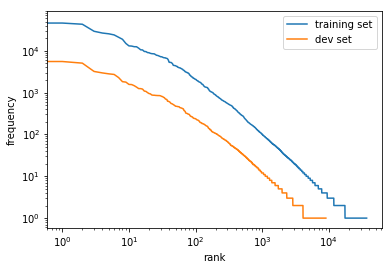

In [20]:
plt.loglog([val for word,val in counts_tr.most_common()])
plt.loglog([val for word,val in counts_dv.most_common()])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend(['training set','dev set']);

**Reflect**: The dataset we are working with does not include capitalization. How do you think this figure would change if capitalization distinctions were included?

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.4:** Implement `preproc.prune_vocabulary` (0.25 points)
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [21]:
reload(preproc);

In [22]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)

In [23]:
len(vocab)

4875

In [24]:
i = 94
print(len(x_dv[i]),len(x_dv_pruned[i]))
print(sum(x_dv[i].values()),sum(x_dv_pruned[i].values()))

88 79
187 176


# 2. Linear classification

Now you'll implement the linear classification rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

You will use these functions in all classifiers in this assignment.

Total: 2 points for 4650, 1 point for 7650.

In [25]:
from gtnlplib import clf_base
reload(clf_base)

from gtnlplib import constants
reload(constants);

Recall from class and the reading that the feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature.

- **Deliverable 2.1**: Implement the function ```make_feature_vector``` in ```clf_base.py```. (1 point for 4650, 0.5 points for 7650)
- **Test**: `tests/test_classifier.py:test_d2_1_featvec`

Note that you must also include the offset feature, ```gtnlplib.constants.OFFSET```.

Desired output is shown below:

In [26]:
fv = clf_base.make_feature_vector({'test':1,'case':2},'1980s')

In [27]:
print(fv)

{('1980s', 'test'): 1, ('1980s', 'case'): 2, ('1980s', '**OFFSET**'): 1}


Let's compute the entire set of labels.

In [28]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'1980s', 'pre-1980', '1990s', '2000s'}


Now implement the prediction rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

- **Deliverable 2.2**: Implement the function ```predict``` in ```clf_base.py```. (1 point for 4650, 0.5 points for 7650)
- **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

- A predicted label
- The scores of all labels

This function will be called **a lot**, so try to make it fast. You don't need to do anything crazy, but avoid making your code do silly extra work. It's worth trying out a couple different versions using %%timeit.

You can test this function using these simple hand-crafted weights.

In [29]:
from collections import defaultdict

In [30]:
# weight vectors must be defaultdicts
theta_hand = defaultdict(float,
                         {('2000s','money'):0.1,
                          ('2000s','name'):0.2,
                          ('1980s','tonight'):0.1,
                          ('2000s','man'):0.1,
                          ('1990s','fly'):0.1,
                          ('pre-1980',constants.OFFSET):0.1
                         })

In [31]:
clf_base.predict(x_tr_pruned[0],theta_hand,labels)

('2000s',
 {'1980s': 0.0, '1990s': 0.0, '2000s': 1.3000000000000003, 'pre-1980': 0.1})

Now let's see how good these weights are, by evaluating on the dev set.

In [32]:
from gtnlplib import evaluation
reload(evaluation);

In [33]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = clf_base.predict_all(x_dv_pruned,theta_hand,labels)
print(evaluation.acc(y_hat,y_dv))

0.3422222222222222


# 3. Naive Bayes

You'll now implement a Naive Bayes classifier, as described in chapter 1 of the notes.

Total: 2 points

In [34]:
from gtnlplib import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```get_corpus_counts``` in ```naive_bayes.py```. (0.5 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [35]:
eighties_counts = naive_bayes.get_corpus_counts(x_tr_pruned,y_tr,"1980s");
print(eighties_counts['today'])
print(eighties_counts['yesterday'])

50.0
14.0


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. (0.5 points)
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.

Hint: note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [36]:
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",0.1,vocab)

Probabilities must sum to one! (or very close)

In [37]:
sum(np.exp(list(log_pxy.values())))

0.9999999999998161

Let's look at the log-probabilities of the words from the hand-tuned weights

In [38]:
print({word:log_pxy[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.689562807416871, 'name': -7.5683247138169865, 'tonight': -6.2166375570076395, 'man': -6.631876946457978, 'fly': -8.636944126361056, '**OFFSET**': 0.0}


In [39]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",10,vocab)

In [40]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.801363512554179, 'name': -7.691160372420565, 'tonight': -6.4054072405225515, 'man': -6.808471387093178, 'fly': -8.60745110429472, '**OFFSET**': 0.0}


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. (0.5 points)
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```clf_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes.
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [41]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [42]:
clf_base.predict(x_tr_pruned[155],theta_nb,labels)

('2000s',
 {'1980s': -2153.0199277981355,
  '1990s': -2125.1966084804503,
  '2000s': -2099.2474010561396,
  'pre-1980': -2136.8348423968023})

In [43]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.46444444444444444


In [44]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.46444444444444444

In [45]:
# execute this block to write predictions for the test set
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')

In [46]:
# you can't run this, but this how the grading code works
y_hat_te = evaluation.read_predictions('nb-test.preds')
evaluation.acc(y_hat_te,y_te)

0.5577777777777778

- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  (0.5 points)
- **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

In [47]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [48]:
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

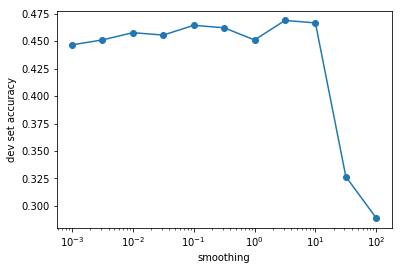

In [49]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

In [50]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

In [51]:
# you can't run this
y_hat = evaluation.read_predictions('nb-best-test.preds')
print(evaluation.acc(y_hat,y_te))

0.5555555555555556


# 4. Perceptron 

Total: 1.5 points

The perceptron update is,

\begin{align}
\hat{y} = & \text{argmax}_y \theta^\top f(x,y)\\
\theta \gets & \theta + f(x,y) - f(x,\hat{y})
\end{align}

You will now implement this classifier, using the file ```gtnlplib/perceptron.py```

In [52]:
from gtnlplib import perceptron
reload(perceptron);

- **Deliverable 4.1**: Implement the perceptron *update*, $f(x,y) - f(x,\hat{y})$, in the function ```perceptron_update``` in ```perceptron.py```. (0.5 points)
- **Test**: `tests/test_perceptron.py:test_d4_1_perc_update`

In [53]:
theta_perc = defaultdict(float)

In [54]:
# no update when the prediction is correct
i=20
update = perceptron.perceptron_update(x_tr_pruned[i],y_tr[i],theta_perc,labels)
print(update)

defaultdict(<class 'float'>, {})


In [55]:
# update when the prediction is incorrect
i=110
y_hat,_ = clf_base.predict(x_tr_pruned[i],theta_perc,labels)
update =perceptron.perceptron_update(x_tr_pruned[i],y_tr[i],theta_perc,labels)
print(list(update.items())[:5])
print(len(update))
print(y_tr[i],constants.OFFSET,update[((y_tr[i],constants.OFFSET))])
print(y_hat,constants.OFFSET,update[((y_hat,constants.OFFSET))])

[(('2000s', 'with'), 1), (('2000s', 'her'), 1), (('2000s', 'lips'), 1), (('2000s', 'yeah'), 1), (('2000s', 'shes'), 2)]
122
2000s **OFFSET** 1
1980s **OFFSET** -1.0


In [56]:
update[(('1980s','with'))]

-1.0

In [57]:
len(update)

122

Now implement the perceptron algorithm. Your implementation should take as inputs:

- The training instances $x$
- The training labels $y$
- The number of iterations to train

It should use your ```update``` function, and it should return:

- weights $\theta$
- a list of the weights at each iteration


- **Deliverable 4.2**: Implement ```estimate_perceptron``` in ```perceptron.py``` (1 point)
- **Test**: `tests/test_perceptron.py:test_d4_2a_perc_estimate`

In [58]:
reload(perceptron);

In [59]:
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned[:10],y_tr[:10],3)

In [60]:
print(theta_perc[('1980s','its')])
print(theta_perc[('1980s','what')])

-15.0
4.0


For reference, here is the running time on a relatively modern consumer-grade machine:

In [274]:
%%timeit
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned,y_tr,20)

11.3 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned,y_tr,20)

In [62]:
# run this to plot the accuracy over iterations
def plot_accs(weight_history,x_tr=x_tr_pruned,y_tr=y_tr,x_dv=x_dv_pruned,y_dv=y_dv):
    tr_accs = []
    dv_accs = []
    for theta in weight_history:
        tr_accs.append(evaluation.acc(clf_base.predict_all(x_tr,theta,labels),y_tr))
        dv_accs.append(evaluation.acc(clf_base.predict_all(x_dv,theta,labels),y_dv))
    plt.plot(tr_accs,'--')
    plt.plot(dv_accs)
    plt.xlabel('iteration')
    plt.ylabel('accuracy');
    plt.legend(['training','dev'],loc='lower right');
    return tr_accs,dv_accs

In [63]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_perc,labels)
print(evaluation.acc(y_hat,y_dv));

0.4311111111111111


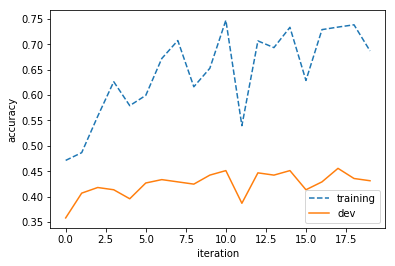

In [64]:
plot_accs(theta_perc_history);

In [65]:
# execute this code to write the predictions on the dev and training data
y_hat_dv = clf_base.predict_all(x_dv_pruned,theta_perc,labels)
evaluation.write_predictions(y_hat_dv,'perc-dev.preds')
y_hat_te = clf_base.predict_all(x_te_pruned,theta_perc,labels)
evaluation.write_predictions(y_hat_te,'perc-test.preds')

In [66]:
y_hat = evaluation.read_predictions('perc-dev.preds')
print(evaluation.acc(y_hat,y_dv))

0.4311111111111111


# 5. Logistic regression

Total: 1.75 points

You will implement logistic regression in PyTorch.

## 5.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array. 

- **Deliverable 5.1**: Implement `preproc.py:make_numpy()` (0.5 points)
- **Test**: `test_pytorch/test_d5_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [69]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [70]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [71]:
reload(preproc);

In [72]:
X_tr = preproc.make_numpy(x_tr_pruned,vocab)
X_dv = preproc.make_numpy(x_dv_pruned,vocab)
X_te = preproc.make_numpy(x_te_pruned,vocab)

In [73]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['1980s', '1990s', '2000s', 'pre-1980']


In [74]:
Y_tr = np.array([label_set.index(y_i) for y_i in y_tr])
Y_dv = np.array([label_set.index(y_i) for y_i in y_dv])

In [75]:
len(set(Y_tr))

4

## 5.2 Building a logistic regression model

- **Deliverable 5.2**: Complete `logreg.build_linear` (0.25 points)
- **Test**: `tests/test_pytorch.py:test_d5_2_logreg`

In [76]:
from gtnlplib import logreg
reload(logreg);

In [77]:
torch.manual_seed(765);

In [78]:
X_tr_var = Variable(torch.from_numpy(X_tr.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te.astype(np.float32)))

It's always a good idea to check the dimensions of your data first.

In [79]:
print(X_tr_var.size())
print(X_dv_var.size())

torch.Size([4000, 4875])
torch.Size([450, 4875])


In [80]:
model = logreg.build_linear(X_tr,Y_tr)

In [81]:
scores = model.forward(X_dv_var)
print(scores)

Variable containing:
-0.7673 -0.7583 -0.3767  0.0325
 0.1110 -0.3801 -0.3979  0.1642
-1.8015 -0.5595 -3.5092  0.9633
               ⋮                
-0.3965  0.0962 -0.4972 -0.1959
-0.1721 -0.5167 -0.2574  0.1571
-0.3643  0.0312 -0.4181  0.4564
[torch.FloatTensor of size 450x4]



## 5.3 Adding a log-softmax layer

We're done it for you in PyTorch. Write your own log-softmax function in numpy and verify the results.

- **Deliverable 5.3**: Complete `logreg.log_softmax` (0.25 points)
- **Test**: `tests/test_pytorch.py:test_d5_3_log_softmax`

In [82]:
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [83]:
model.forward(X_dv_var)[:3]

Variable containing:
-1.7426 -1.7336 -1.3520 -0.9427
-1.1841 -1.6752 -1.6930 -1.1309
-3.0214 -1.7793 -4.7291 -0.2566
[torch.FloatTensor of size 3x4]

In [84]:
model.forward(X_dv_var)[:3].exp()

Variable containing:
 0.1751  0.1767  0.2587  0.3896
 0.3060  0.1873  0.1840  0.3227
 0.0487  0.1688  0.0088  0.7737
[torch.FloatTensor of size 3x4]

Notice that each row sums up to one.

In [85]:
model.forward(X_dv_var)[:3].exp().sum(dim=1)

Variable containing:
 1
 1
 1
[torch.FloatTensor of size 3]

In [86]:
reload(logreg);

In [87]:
logreg.log_softmax(scores[:3].data.numpy()) 

array([[-1.742636  , -1.7335784 , -1.3519608 , -0.9427422 ],
       [-1.1840885 , -1.6752369 , -1.692963  , -1.1309159 ],
       [-3.0213723 , -1.7793286 , -4.729114  , -0.25659686]],
      dtype=float32)

These should be very close to the PyTorch results.

## 5.4 Negative Log-Likelihood Loss

A loss function tells you how well your model is doing. It produces gradients that allows the optimizer to tune the model weights. We've done the Pytorch call for you, try implementing this yourself in numpy!

- **Deliverable 5.4**: Complete `logreg.nll_loss` (0.25 points)
- **Test**: `tests/test_pytorch.py:test_d5_4_nll_loss`

In [88]:
loss = torch.nn.NLLLoss()

In [89]:
Y_tr_var = Variable(torch.from_numpy(Y_tr))
Y_dv_var = Variable(torch.from_numpy(Y_dv))

In [90]:
logP = model.forward(X_tr_var)
print(loss.forward(logP,Y_tr_var))

Variable containing:
 1.5013
[torch.FloatTensor of size 1]



In [91]:
reload(logreg);

In [92]:
logreg.nll_loss(logP.data.numpy(), Y_tr)

1.5013313

Again, This should be very similar to the PyTorch result above.

## 5.5 Putting everything together

An optimizer can be used to actually learn the weights. We provide the complete code below that you can train on in `logreg.train_model`.

In [93]:
reload(logreg);

In [94]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [95]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.29555555555555557
Epoch 21: Dev Accuracy: 0.29555555555555557
Epoch 31: Dev Accuracy: 0.31333333333333335
Epoch 41: Dev Accuracy: 0.30666666666666664
Epoch 51: Dev Accuracy: 0.35777777777777775
Epoch 61: Dev Accuracy: 0.32222222222222224
Epoch 71: Dev Accuracy: 0.34444444444444444
Epoch 81: Dev Accuracy: 0.3333333333333333
Epoch 91: Dev Accuracy: 0.33111111111111113


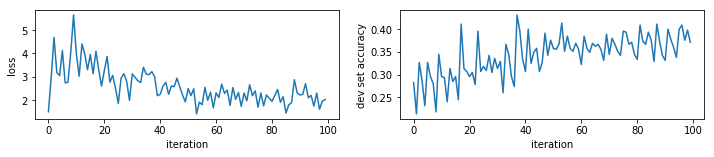

In [96]:
logreg.plot_results(losses,accuracies)

**Deliverable 5.5**
The noisy progress of the loss and dev set accuracy suggests that something is wrong with our hyperparameters. Tune the inputs to `train_model` until you can get to a dev set accuracy of at least 0.5. (0.5 points)

In [97]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [ ]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

In [99]:
_, Y_hat_dv = model_trained.forward(X_dv_var).max(dim=1)
np.save('logreg-es-dev.preds.npy', Y_hat_dv.data.numpy())

In [100]:
acc = evaluation.acc(np.load('logreg-es-dev.preds.npy'),Y_dv_var.data.numpy())
print(acc)

0.5044444444444445


In [101]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('logreg-es-test.preds.npy', Y_hat_te.data.numpy())

In [102]:
# You can't run this
acc = evaluation.acc(np.load('logreg-es-test.preds.npy'),Y_te_var.data.numpy())
print(acc)

0.48


# 6. Feature analysis

Total: 1 point


## 6.1 Top Features for Naive Bayes and Perceptron

- **Deliverable 6.1**: Implement ```get_top_features_for_label_numpy``` in ```features.py```. (0.5 points)
- **Test**: `tests/test_features.py:test_d6_1_topfeat_numpy`

In [103]:
from gtnlplib import features
reload(features);

In [104]:
features.get_top_features_for_label_numpy(theta_perc,'pre-1980',7)

[(('pre-1980', '**OFFSET**'), 949.0),
 (('pre-1980', 'lord'), 326.0),
 (('pre-1980', 'very'), 293.0),
 (('pre-1980', 'feelin'), 263.0),
 (('pre-1980', 'satisfied'), 251.0),
 (('pre-1980', 'darling'), 247.0),
 (('pre-1980', 'yes'), 235.0)]

In [105]:
features.get_top_features_for_label_numpy(theta_perc,'1990s',7)

[(('1990s', 'cuz'), 452.0),
 (('1990s', 'hit'), 368.0),
 (('1990s', 'sweat'), 342.0),
 (('1990s', 'prove'), 322.0),
 (('1990s', 'yo'), 285.0),
 (('1990s', 'saw'), 271.0),
 (('1990s', 'jam'), 268.0)]

## 6.2 Top Features for Logistic Regression

- **Deliverable 6.2**: Implement ```get_top_features_for_label_torch``` in ```features.py```. (0.5 points)
- **Test**: `tests/test_features.py:test_d6_2_topfeat_torch`

**Hint**: Extract linear layer weights from the PyTorch model.

In [106]:
reload(features);

Load a fixed model so we have reproducible results. Feel free to change it to your own model.

In [107]:
model_test = torch.load('tests/test_weights.torch')

In [108]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'pre-1980',5)

['love', 'lovin', 'and', 'baby', 'on']

In [109]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'1990s',7)

['here', 'power', 'jam', 'saw', 'yeah', 'want', 'yall']

# 7. Feature Engineering

Total: 0.75 points

## 7.1 Example Feature - Token-Type Ratio

You can have features other than bag of words in your model. For example, we can consider the token-type ratio for each song. The token-type ratio is:
\begin{equation}
\frac{\text{length of song in tokens}}{\text{number of distinct types}} = \frac{\sum_m w_m}{\sum_m \delta(w_m > 0)}
\end{equation}

- **Deliverable 7.1**: Implement ```get_token_type_ratio``` in ```features.py```. (0.25 points)
- **Test**: `tests/test_features.py:test_d7_1_token_type_ratio`

Return zero if the length of the song is zero.

In [110]:
reload(features);

Token-type ratios for the first five songs:

In [111]:
[features.get_token_type_ratio(X_tr[i]) for i in range(5)]

[5.083333333333333,
 2.6,
 1.9113924050632911,
 2.318840579710145,
 6.188679245283019]

## 7.2 Binning Your Features

Discretize your token-type ratio feature into bins: 


$\{ [0,1), [1,2), [2,3), [3,4), [4,5), [5,6), [6, \infty) \}$.

For each instance, there will be seven new features (one per bin). Exactly one of these features will have the value one; all others will have the value zero.

Use `np.concatenate` or `np.hstack` to concatenate your result to the variable X_tr.

- **Deliverable 7.2**: Implement ```concat_ttr_binned_features``` in ```features.py```. (0.5 points)
- **Test**: `tests/test_features.py:test_d7_2_discretize`

In [112]:
reload(features);

In [113]:
X_tr.shape

(4000, 4875)

In [114]:
X_tr_new = features.concat_ttr_binned_features(X_tr)
print(X_tr_new)
print(X_tr_new.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4000, 4882)


In [115]:
X_dv_new = features.concat_ttr_binned_features(X_dv)
X_te_new = features.concat_ttr_binned_features(X_te)
X_tr_var = Variable(torch.from_numpy(X_tr_new.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv_new.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te_new.astype(np.float32)))

In [116]:
model = logreg.build_linear(X_tr_var,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))
loss = torch.nn.NLLLoss()

See if these features help!

In [117]:
model,losses,accuracies = logreg.train_model(loss,model,X_tr_var,Y_tr_var,
                                             Y_dv_var=Y_dv_var,X_dv_var = X_dv_var,
                                             num_its=500,status_frequency=100)

Epoch 1: Dev Accuracy: 0.31333333333333335
Epoch 101: Dev Accuracy: 0.4
Epoch 201: Dev Accuracy: 0.42444444444444446
Epoch 301: Dev Accuracy: 0.4444444444444444
Epoch 401: Dev Accuracy: 0.4577777777777778


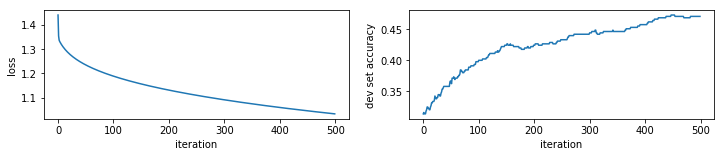

In [118]:
logreg.plot_results(losses,accuracies)

## 7.3 Bakeoff

**Deliverable 7.3**: Try to get the best accuracy possible. 

Some ideas:

- Better features
- Better optimization
- Better classifier, e.g. multilayer neural networks
- Better loss function
- Better preprocessing
- Dropout or other regularization scheme

The current best accuracies from the staff are 55.5% dev, 59.3% test.

### Rubric

Dev set
- $\geq 55\%$: 1 point
- $\geq 54\%$: 0.75 points
- $\geq 53\%$: 0.5 points
- $\geq 51.5\%$: 0.25 points

Test set
- $\geq 58\%$: 1 point
- $\geq 55\%$: 0.75 points
- $\geq 52\%$: 0.5 points
- $\geq 50\%$: 0.25 points
    
### Extra credit
- We will run a Kaggle competition for this bakeoff. More details are coming soon.
- Extra credit will be given to the top three submissions (combined across 4650/7650), by **test set** performance: 1 point, 0.75 points, 0.5 points. 
- Another 1 point of extra credit will be awarded to submissions that are better than the best staff system, on the test set.
- Staff will continue to try to improve their results until the deadline, but we will not tune on test set accuracy.
- **Extra credit will be based on Kaggle submissions.** You don't have to participate in the Kaggle part of the bakeoff, but only Kaggle submissions will be eligible for extra credit.

In [119]:
_, Y_hat_dv = model.forward(X_dv_var).max(dim=1)
np.save('bakeoff-dev.preds.npy', Y_hat_dv.data.numpy())
evaluation.acc(np.load('bakeoff-dev.preds.npy'), Y_dv_var.data.numpy())

0.47333333333333333

In [120]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('bakeoff-test.preds.npy', Y_hat_te.data.numpy())

In [121]:
# You can't run this
evaluation.acc(np.load('bakeoff-test.preds.npy'), Y_te_var.data.numpy())

0.46444444444444444

# 8. 7650 Research Question

(1 point.) CS 4650 students may do this component if they want; if they do, then the assignment will be graded as if they are in 7650. This is optional for CS4650 students, but if you submit something for this part, that is how you will be scored -- we're not taking the max over the two possible scoring options. CS 7650 students must do this part.

You will select a recent research paper that performs *document* classification, using text. Summarize the paper, answering the following questions:

- What are the labels, and how were they obtained?
- Why is it interesting/useful to predict these labels?  
- What classifier(s) do they use, and the reasons behind their choice? Do they use linear classifiers like the ones in this problem set?
- What features do they use? Explain any features outside the bag-of-words model, and why they used them.
- What is the conclusion of the paper? Do they compare between classifiers, between feature sets, or on some other dimension? 
- Give a one-sentence summary of the message that they are trying to leave for the reader.

Your selection of papers is determined by the last digit of your GTID.

- Digits 0-4: choose from ACL 2017, AAAI 2017, EACL 2017
- Digits 5-9: choose from NAACL 2017, KDD 2017, EMNLP 2017

You must choose a paper in the main conference (not workshops). The paper must be at least four pages long. All papers from these conferences are available for free online.